In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import KFold
import random


In [2]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [3]:
# データを格納するリスト
X = []
Z = []

# 画像のサイズ
IMG_SIZE = 224

# 各花のディレクトリのパス
FLOWER_DAISY_DIR = '../input/flowers/daisy'
FLOWER_DANDI_DIR = '../input/flowers/dandelion'
FLOWER_ROSE_DIR = '../input/flowers/rose'
FLOWER_SUNFLOWER_DIR = '../input/flowers/sunflower'
FLOWER_TULIP_DIR = '../input/flowers/tulip'

# フラグを初期化
added_flowers = set()


In [4]:
# データの格納とコメントを追加した関数
def make_train_data(flower_type, DIR):
    if flower_type not in added_flowers:
        added_flowers.add(flower_type)
        # 各花のデータを格納するためのループ
        for img in tqdm(os.listdir(DIR)):
            # ラベルを花の名前に設定
            label = str(flower_type)
            # 画像ファイルのパスを生成
            path = os.path.join(DIR, img)
            # 画像をカラーで読み込み
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            # 画像サイズをリサイズ
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            # データをリストに追加
            X.append(np.array(img))
            Z.append(str(label))


In [5]:
# 各花に対してデータを作成
make_train_data('Daisy', FLOWER_DAISY_DIR)
make_train_data('Dandelion', FLOWER_DANDI_DIR)
make_train_data('Rose', FLOWER_ROSE_DIR)
make_train_data('Sunflower', FLOWER_SUNFLOWER_DIR)
make_train_data('Tulip', FLOWER_TULIP_DIR)


100%|██████████| 984/984 [00:01<00:00, 498.30it/s]


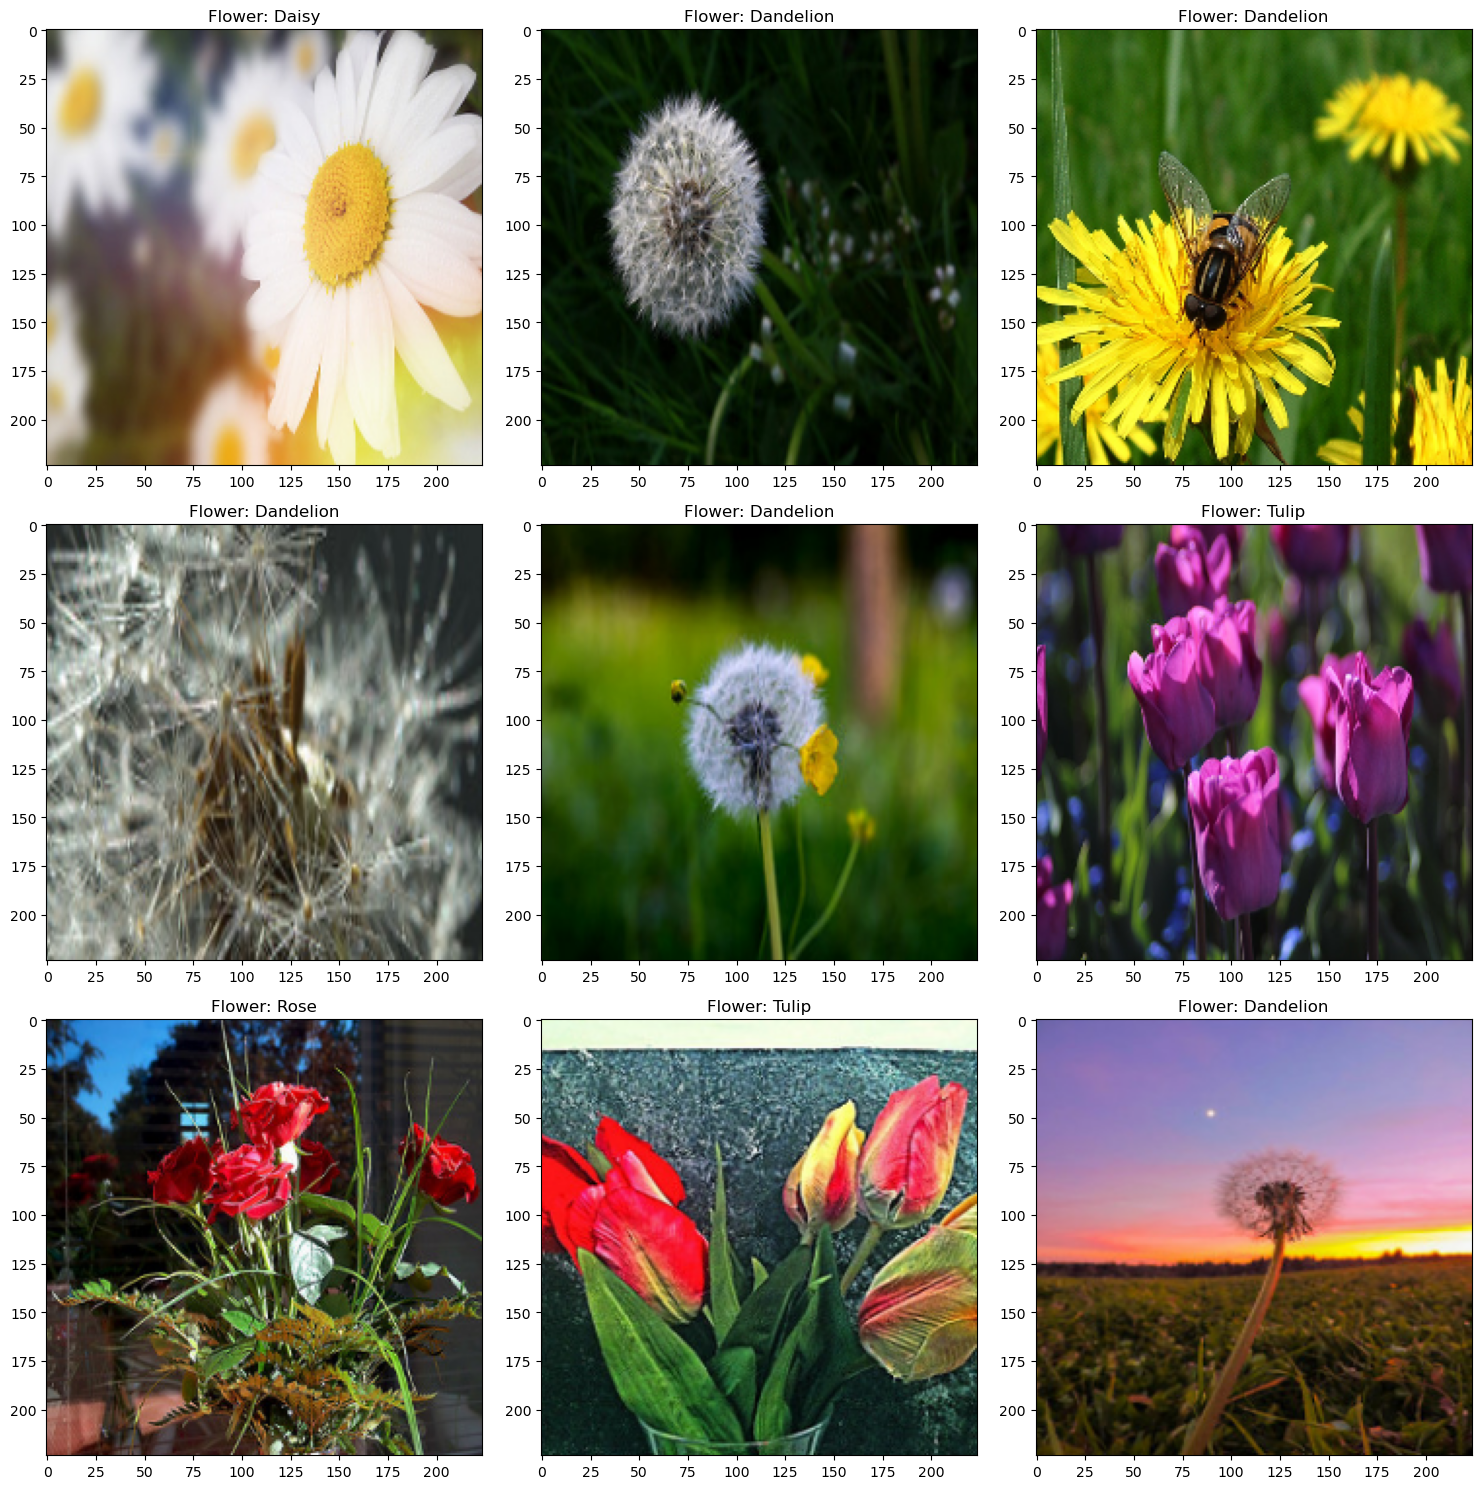

In [6]:
# 3x3のサブプロットを作成
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 15)

# 9つのランダムな画像を選択して表示
for i in range(3):
    for j in range(3):
        # ランダムにインデックスを選択
        random_index = random.randint(0, len(Z) - 1)
        
        # 画像をRGB形式に変換
        img_rgb = cv2.cvtColor(X[random_index], cv2.COLOR_BGR2RGB)
        
        # サブプロットに画像を表示
        ax[i, j].imshow(img_rgb)
        
        # タイトルに花の種類を表示
        ax[i, j].set_title('Flower: ' + Z[random_index])

# グラフを整えて表示
plt.tight_layout()
plt.show()


In [7]:
# 1. データの前処理
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = torch.tensor(Y, dtype=torch.long)
X = np.array(X)
X = X / 255.0  # ピクセル値を正規化
X = torch.tensor(X, dtype=torch.float32)
X = X.permute(0, 3, 1, 2)  # PyTorchはチャネルを先に要求


In [8]:
# データを訓練セットと検証セットに分割
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# データローダーの作成
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)


In [9]:
class CustomVGG(nn.Module):
    def __init__(self, num_classes=5):  # 5種類の花の分類
        super(CustomVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)  # 5クラス分類
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [10]:
# モデルをデバイスに移動
model = CustomVGG().to(device)


In [11]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)


In [12]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Training...'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Validation...'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [13]:
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

# 交差検証の設定
kf = KFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}')
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    Y_train_fold, Y_val_fold = Y[train_idx], Y[val_idx]

    train_dataset_fold = TensorDataset(X_train_fold, Y_train_fold)
    val_dataset_fold = TensorDataset(X_val_fold, Y_val_fold)
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

    model_fold = CustomVGG().to(device)
    optimizer_fold = torch.optim.Adam(model_fold.parameters(), lr=0.001)
    criterion_fold = nn.CrossEntropyLoss()

    # 各フォールドでのモデルの訓練と評価
    train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model_fold, train_loader_fold, val_loader_fold, criterion_fold, optimizer_fold)

    # 各フォールドの結果を保存
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

    # 各フォールドの結果をプロット
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Losses at Fold {fold+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Accuracy at Fold {fold+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Fold 1


Epoch 1/25, Validation...: 100%|██████████| 27/27 [00:02<00:00, 10.51it/s]


Epoch 1/25, Train Loss: 1.48769106026049, Val Loss: 6.24353144786976, Train Acc: 0.26498696785403997, Val Acc: 0.11574074074074074


Epoch 2/25, Validation...: 100%|██████████| 27/27 [00:02<00:00, 10.73it/s]


Epoch 2/25, Train Loss: 1.3877693304309138, Val Loss: 5.252632993238944, Train Acc: 0.27541268462206775, Val Acc: 0.0


Epoch 3/25, Validation...: 100%|██████████| 27/27 [00:02<00:00, 10.75it/s]


Epoch 3/25, Train Loss: 1.3837446217183713, Val Loss: 6.6736419730716285, Train Acc: 0.28236316246741966, Val Acc: 0.0


Epoch 4/25, Validation...: 100%|██████████| 27/27 [00:02<00:00, 10.78it/s]


Epoch 4/25, Train Loss: 1.3818115768609223, Val Loss: 6.827637977070278, Train Acc: 0.281783955980307, Val Acc: 0.0


Epoch 5/25, Training...:  20%|██        | 22/108 [00:20<01:21,  1.06it/s]


KeyboardInterrupt: 

In [ ]:
# 平均損失と精度の計算
avg_train_loss = np.mean([np.mean(losses) for losses in all_train_losses])
avg_val_loss = np.mean([np.mean(losses) for losses in all_val_losses])
avg_train_acc = np.mean([np.mean(accs) for accs in all_train_accuracies])
avg_val_acc = np.mean([np.mean(accs) for accs in all_val_accuracies])

print(f'Average Train Loss: {avg_train_loss}, Average Validation Loss: {avg_val_loss}')
print(f'Average Train Accuracy: {avg_train_acc}, Average Validation Accuracy: {avg_val_acc}')


In [ ]:
# 各フォールドの結果をまとめてプロット
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
for i in range(len(all_train_losses)):
    plt.plot(all_train_losses[i], label=f'Train Fold {i+1}')
    plt.plot(all_val_losses[i], label=f'Val Fold {i+1}', linestyle='--')
plt.title('Train and Validation Losses Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
for i in range(len(all_train_accuracies)):
    plt.plot(all_train_accuracies[i], label=f'Train Fold {i+1}')
    plt.plot(all_val_accuracies[i], label=f'Val Fold {i+1}', linestyle='--')
plt.title('Train and Validation Accuracies Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
